In [1]:
from __future__ import print_function
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import ROOT
%jsroot on
from ROOT import gROOT, gStyle, gDirectory, gPad

from array import array

import constants
import crv_event
import crv_spill
import utils
import geometry
import geometry_constants
import filepath
import portROOT2pd

gROOT.Reset()
gROOT.SetBatch(1)
gROOT.ProcessLine( "gErrorIgnoreLevel = 1001;")
gStyle.SetOptStat(111110)
gStyle.SetOptFit(0)
gStyle.SetLineScalePS(0.3)

TARGET_OVERVOLTAGE = 3 # V
MV_PER_TRIM = -2. # mV/DAC
MV_PER_BULK = 20. # mV/DAC

topdir = os.path.dirname(os.path.abspath("__file__"))
settings_dir = os.path.join(topdir,"settings")

fileList = filepath.getfilelist(["bulk_scan_crvaging016_0"],"recoROOT",8)[0]
DeltaBulkNorm = filepath.datatag["bulk_scan_crvaging016_0"]["bulk"]
print(fileList)

nSmooth = 1 
tdict = {'*':[["temperatureCMB[0][0]","temperatureCMB[1][0]","temperatureCMB[2][0]",
               "temperatureCMB[3][0]","temperatureCMB[4][0]","temperatureCMB[5][0]",
               "temperatureCMB[6][0]","temperatureCMB[7][0]"],
              ["temperatureFEB[0:8]"]]}


Welcome to JupyROOT 6.28/10
['/pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/39/65/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002052_000.root', '/pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/bd/31/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002053_000.root', '/pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/24/2f/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002054_000.root']


Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002052_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002053_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002054_000.root


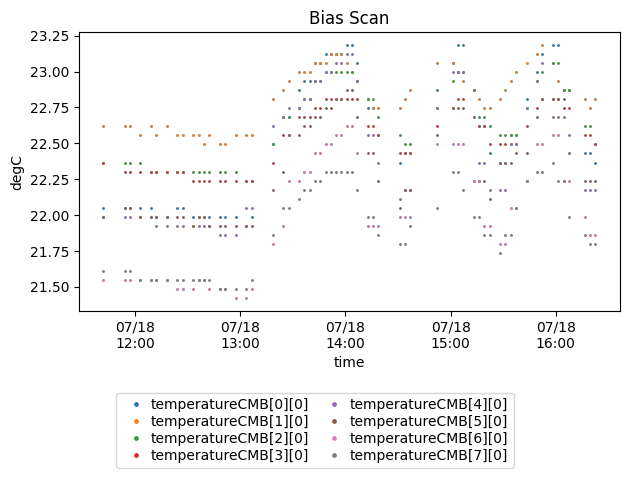

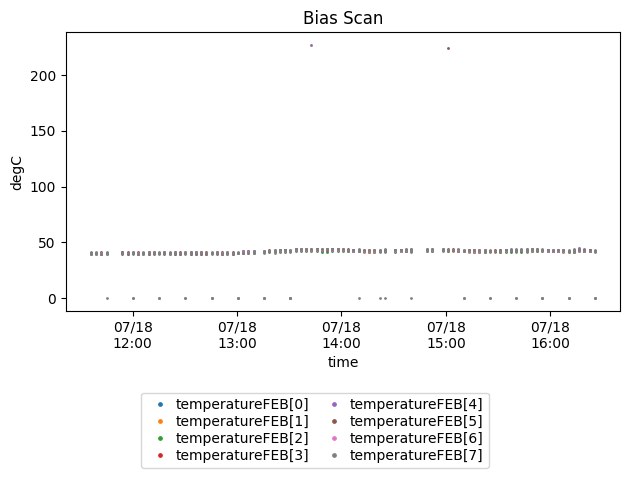

In [2]:
tfig = utils.plot_dqm(fileList, tdict, '& 0xfffffffffffffe == 0x0', False, nSmooth, True, "Bias Scan;time;degC") 
# tfig = utils.plot_dqm(fileList, tdict, ' == 0x0', False, nSmooth, True, "Bias Scan;time;degC") 

In [3]:
import pandas as pd
from scipy import stats
import settings_file

def PortToDFwithBulk(fileList, bulkList):
    df = portROOT2pd.PortToDF(fileList,{'bulkRelative':bulkList})
    return df

def CalibrateByScan(df0, targetVover = TARGET_OVERVOLTAGE, nr = 4, nc = 4, ifDrawCorr = True):
    FEBs = df0['FEB'].unique()
    FEBs = np.sort(FEBs)

    targetBulkOver = targetVover * 1000. / MV_PER_BULK

    df_calib = pd.DataFrame()

    maintitle = "calibration"
    xtitle = "Relative Bulk Settings [DAC unit]"
    ytitle = "SPE [ADC*ns/PE]"
     
    for FEB in FEBs:
        fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(5*nc, 5*nr), sharey=True)
        plt.subplots_adjust(wspace=0)
        fig.subplots_adjust(top=0.24*nr/(0.04+0.24*nr))
        plt.suptitle(maintitle + ", FEB "+ str(FEB))
    
        for hdmi, ax in enumerate(axs.flatten()):
            ax.set_xlabel(xtitle)
            if(hdmi%4 == 0):
                ax.set_ylabel(ytitle)
            for inhdmi_chan in range(4):
                chan = hdmi*4+inhdmi_chan

                df0_ = df0.query("FEB==%i & ch==%i"%(FEB, chan)).reset_index()
                # display(df0_)
                x = df0_['bulkRelative']
                y1 = df0_['calibRaw']
                y2 = df0_['calibAdj']

                mask11 = ~np.isnan(y1) 
                mask12 = (y1!=0)
                mask1 = mask11 & mask12
                x1 = x[mask1]
                y1 = y1[mask1]

                if ifDrawCorr:
                    mask21 = ~np.isnan(y2) 
                    mask22 = (y2!=0)
                    mask2 = mask21 & mask22
                    x2 = x[mask2]
                    y2 = y2[mask2]

                bulkRelativeSetting1 = np.nan
                yref1 = np.nan
                bulkRelativeSetting2 = np.nan
                yref2 = np.nan

                if len(x1)>1:
                    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1.astype(float), y1.astype(float))
                    xintercept1 = - intercept1 / slope1
                    bulkRelativeSetting1 = round(xintercept1 + targetBulkOver, 1)
                    yref1 = bulkRelativeSetting1 * slope1 + intercept1
                
                    markers1 = ax.plot(x1, y1, 'o', label='Chan: %d raw, y = %.1f + %.1f * x, (%.1f, %.1f)'%(chan, intercept1, slope1, bulkRelativeSetting1, yref1))
                    ax.plot(x1, slope1 * x1 + intercept1, '--', color = markers1[0].get_color(), linewidth=0.7)
                else:
                    print(FEB, chan, list(df0_['bulkRelative']), list(df0_['calibRaw']), list(df0_['calibAdj']))
                
                if ifDrawCorr and len(x2) > 0:
                    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2.astype(float), y2.astype(float))
                    xintercept2 = - intercept2 / slope2
                    bulkRelativeSetting2 = round(xintercept2 + targetBulkOver, 1)
                    yref2 = bulkRelativeSetting2 * slope2 + intercept2

                    markers2 = ax.plot(x2, y2, 'v', label='Chan: %d corr., y = %.1f + %.1f * x, (%.1f, %.1f)'%(chan, intercept2, slope2, bulkRelativeSetting2, yref2), color = markers1[0].get_color())
                    ax.plot(x2, slope2 * x2 + intercept2, ':', color = markers1[0].get_color(), linewidth=0.7)

                ax.legend(fontsize='small')

                df_calib_ = pd.DataFrame()
                df_calib_['FEB'] = [FEB]
                df_calib_['ch'] = [chan]
                df_calib_['bulkRelativeSettingRaw'] = [bulkRelativeSetting1]
                df_calib_['SPErefRaw'] = [yref1]
                if ifDrawCorr:
                    df_calib_['bulkRelativeSettingCorr'] = [bulkRelativeSetting2]
                    df_calib_['SPErefCorr'] = [yref2]
                
                df_calib = pd.concat([df_calib,df_calib_], ignore_index=True)

    return df_calib   

3 63 [-25, 0, 25] [0.0, 0.0, 0.0] [0.0, 0.0, 0.0]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4 44 [-25, 0, 25] [0.0, 0.0, 0.0] [0.0, 0.0, 0.0]
4 45 [-25, 0, 25] [0.0, 0.0, 0.0] [0.0, 0.0, 0.0]
4 46 [-25, 0, 25] [0.0, 0.0, 0.0] [0.0, 0.0, 0.0]
4 47 [-25, 0, 25] [0.0, 0.0, 220.7259979248047] [0.0, 0.0, 0.0]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


7 56 [-25, 0, 25] [0.0, 0.0, 0.0] [0.0, 0.0, 0.0]


FEB  ch  bulkRelativeSettingRaw   SPErefRaw  bulkRelativeSettingCorr  \
0      0   0                   -88.7  366.234469                    -81.4   
1      0   1                   -81.6  374.587637                    -76.4   
2      0   2                   -82.7  376.328075                    -76.4   
3      0   3                   -89.5  372.090296                    -83.0   
4      0   4                   -81.7  362.005787                    -76.2   
..   ...  ..                     ...         ...                      ...   
507    7  59                  -109.9  366.877531                   -105.0   
508    7  60                  -109.5  353.708905                   -104.5   
509    7  61                  -110.0  353.344560                   -105.3   
510    7  62                  -108.9  358.622492                   -104.1   
511    7  63                  -111.3  359.202222                   -106.3   

     SPErefCorr  
0    389.580253  
1    395.127817  
2    398.996608  
3    394.162116  
4    383.511014  
..          ...  
507  383.232638  
508  369.988378  
509  368.917266  
510  374.680494  
511  375.301267  

[512 rows x 6 columns]

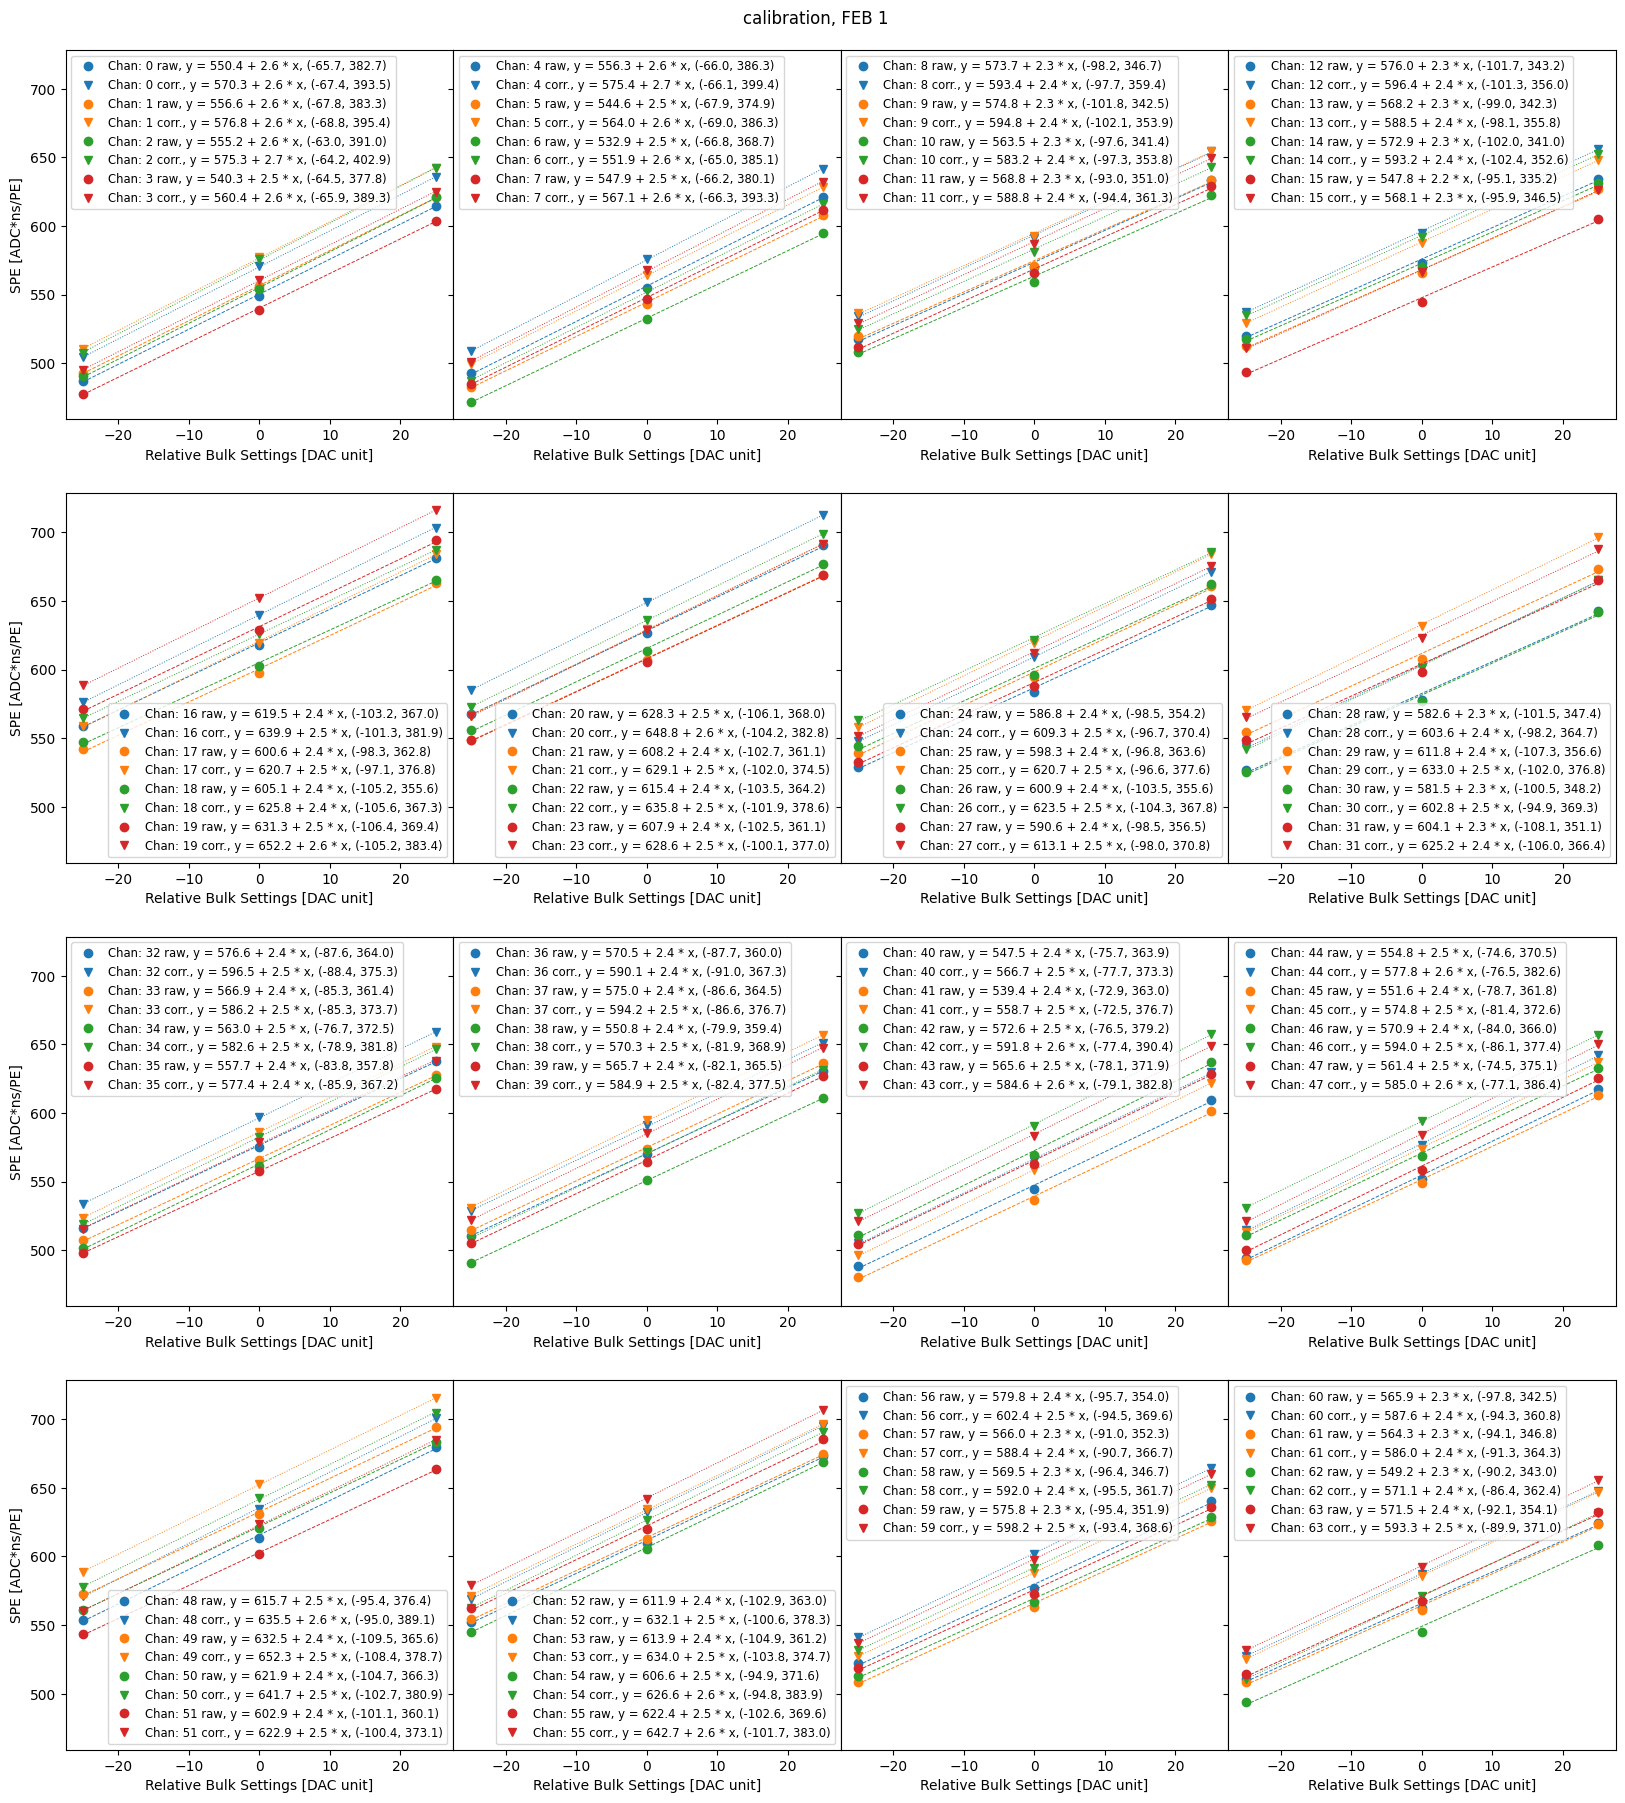

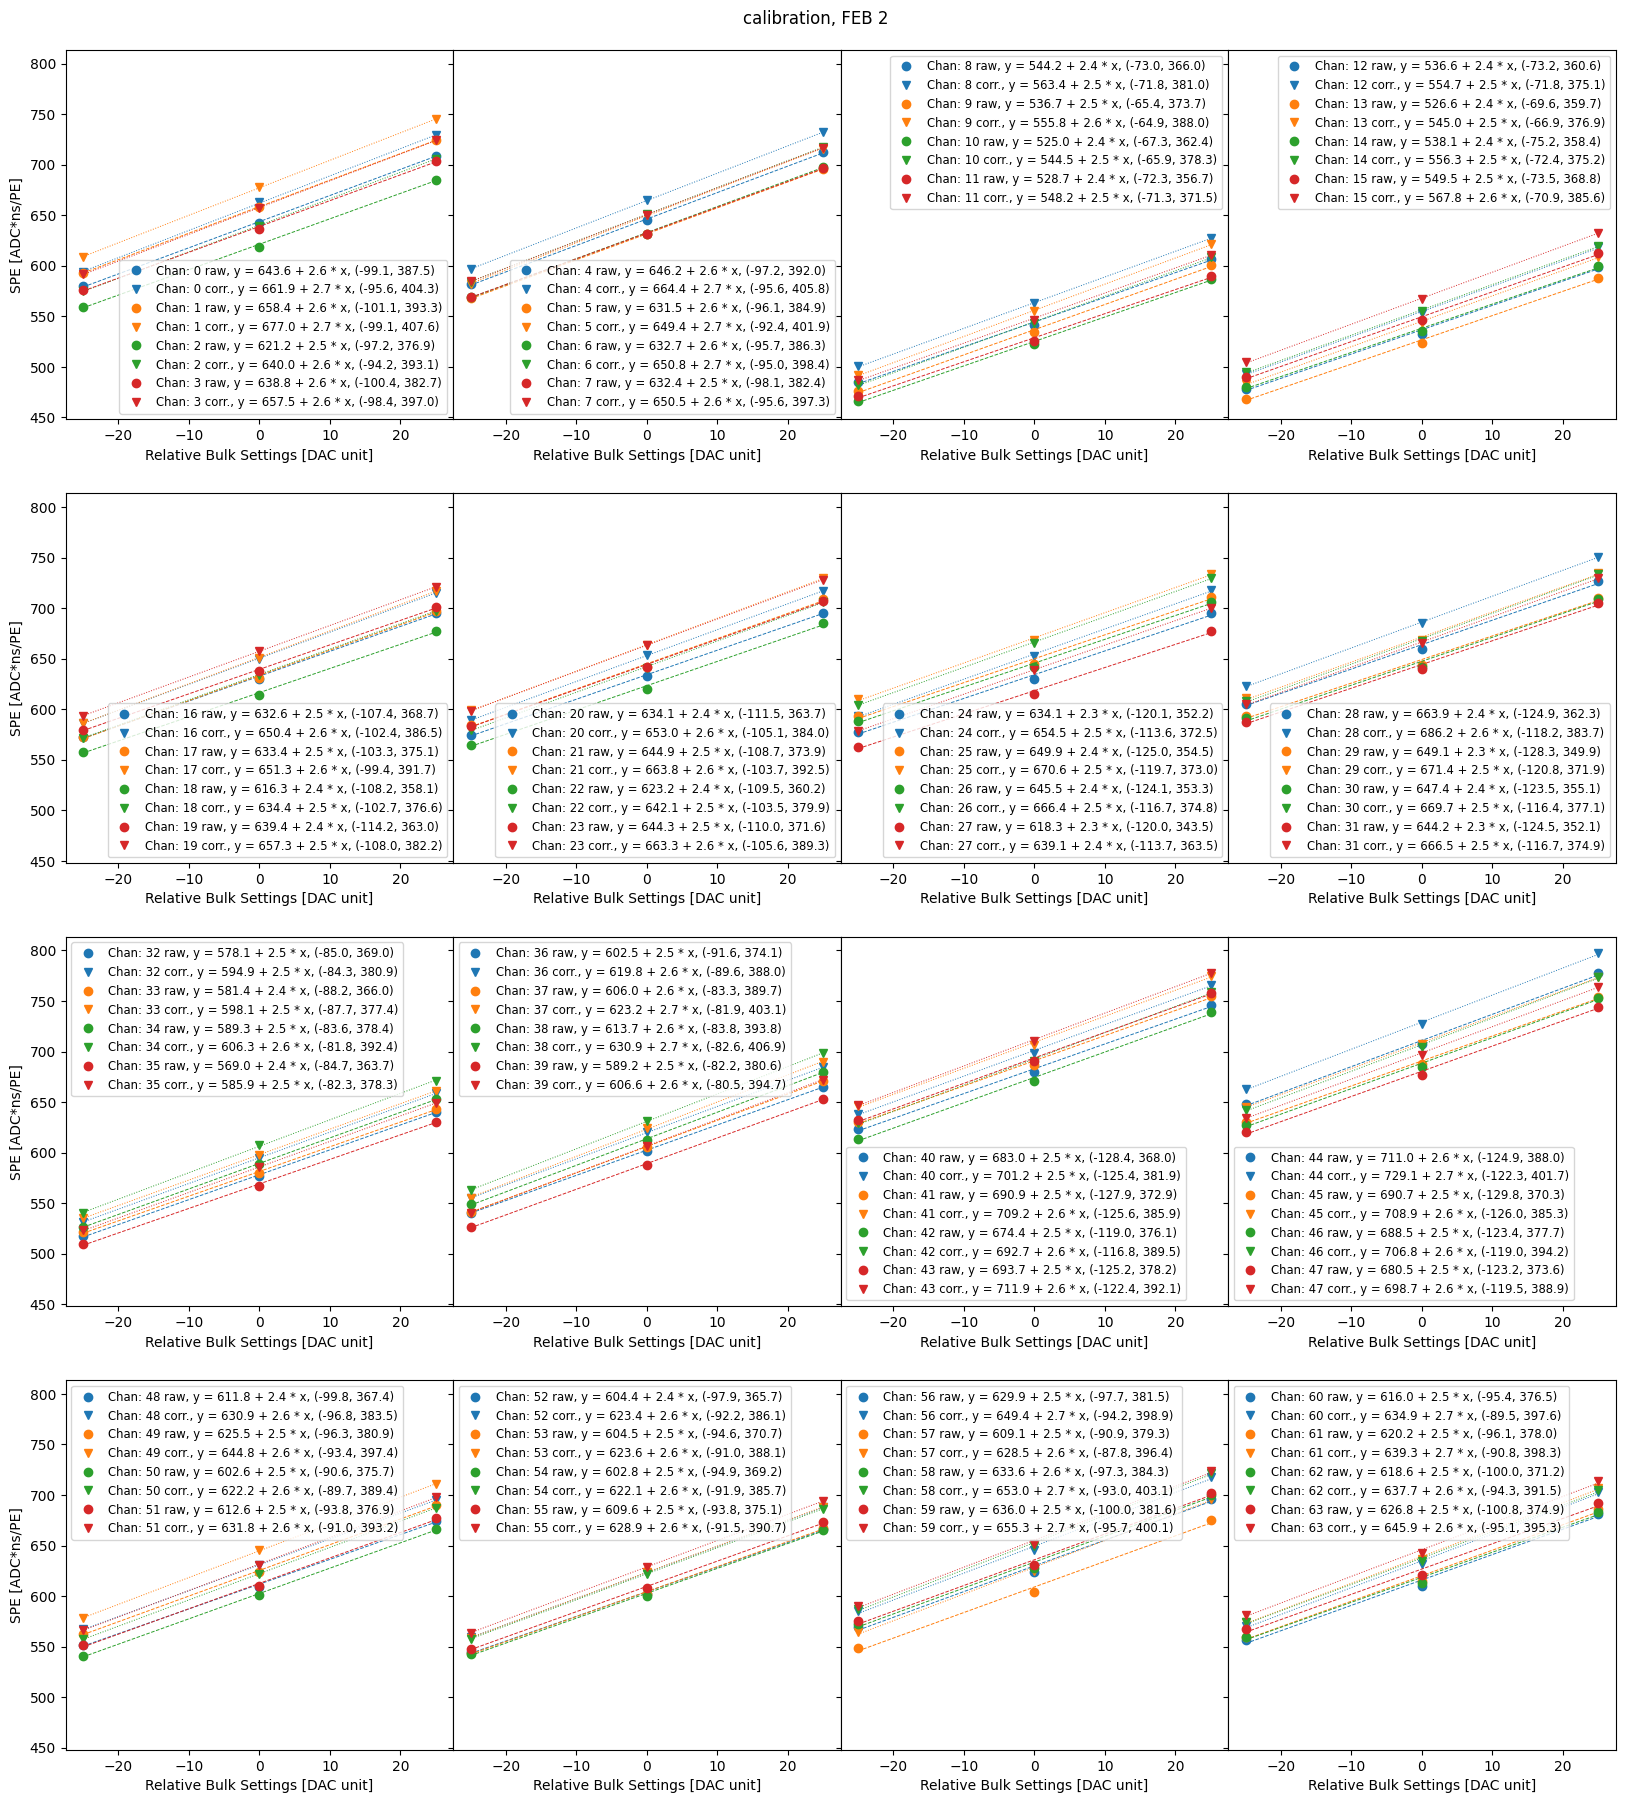

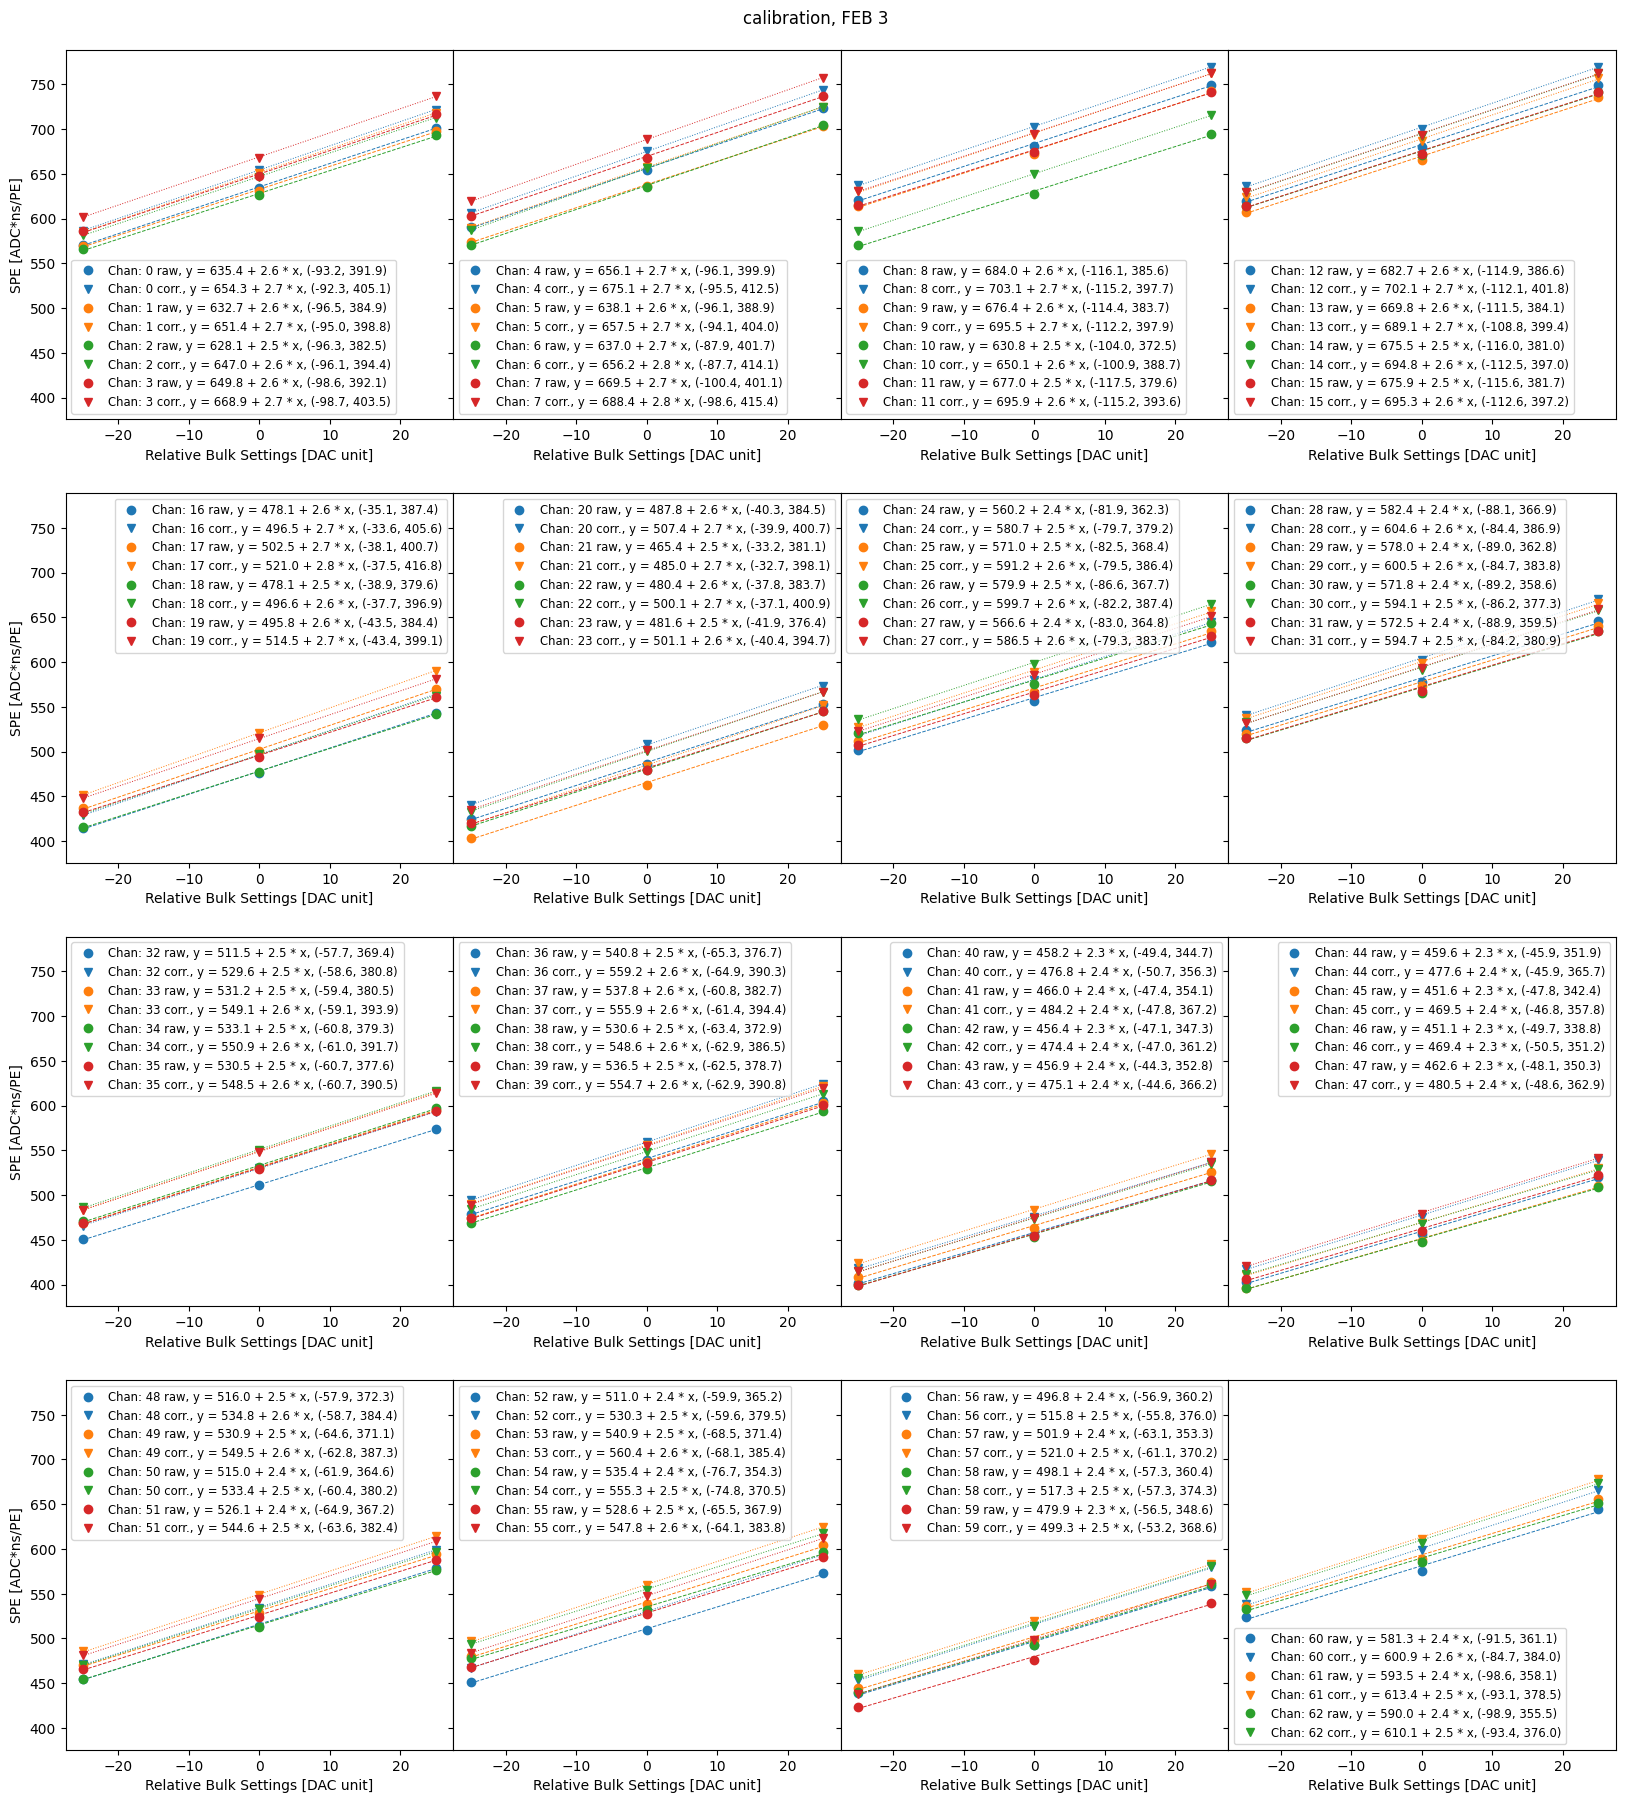

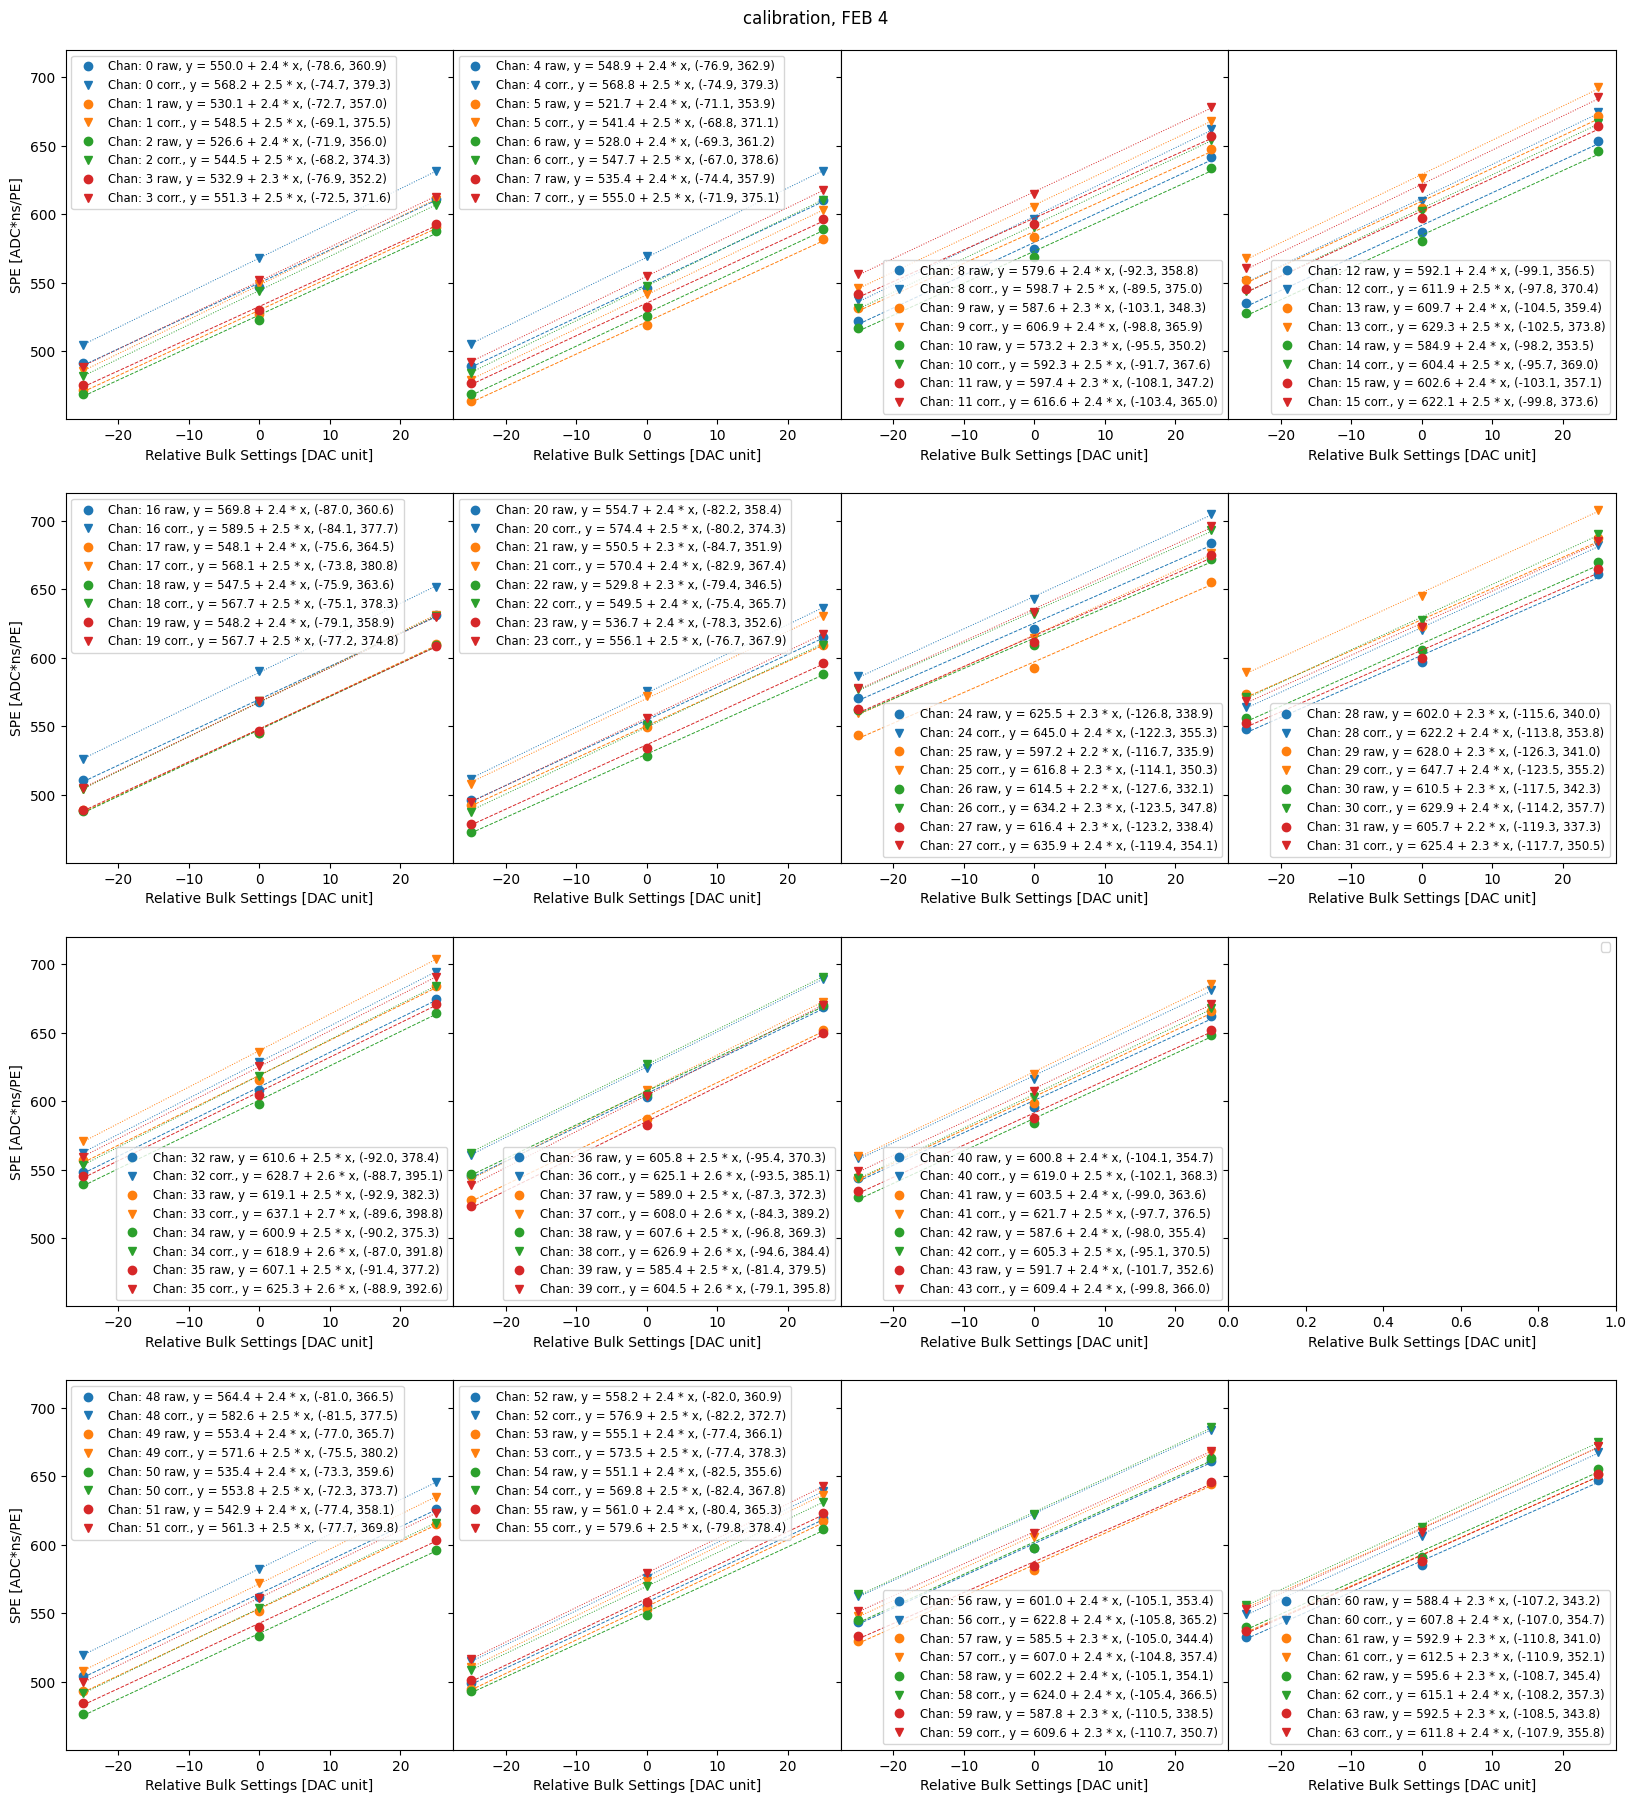

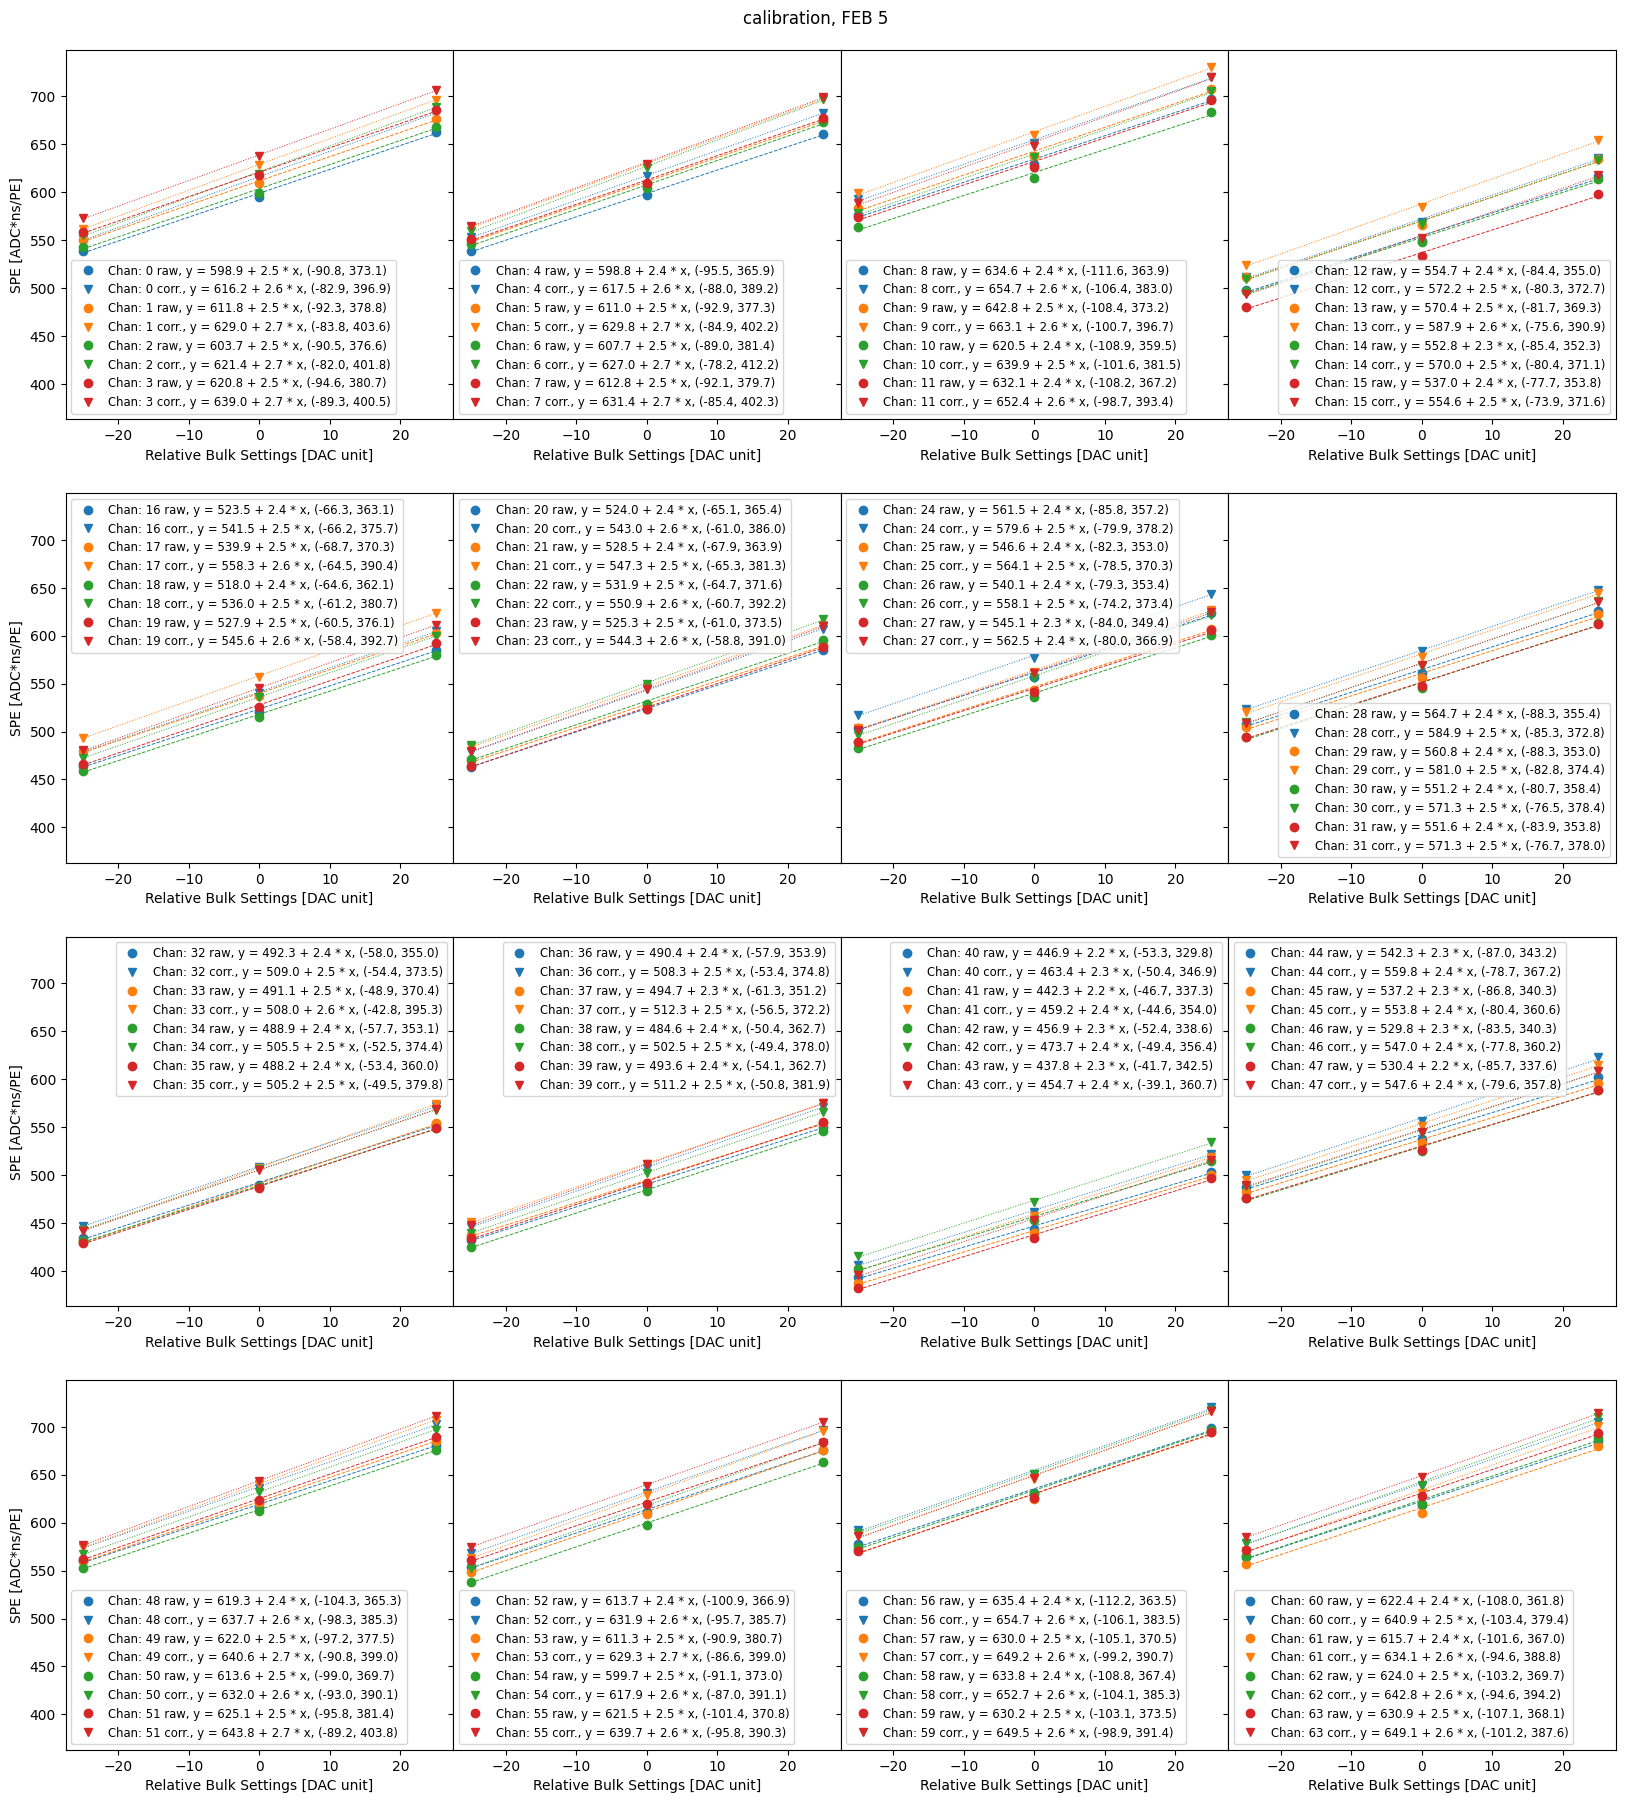

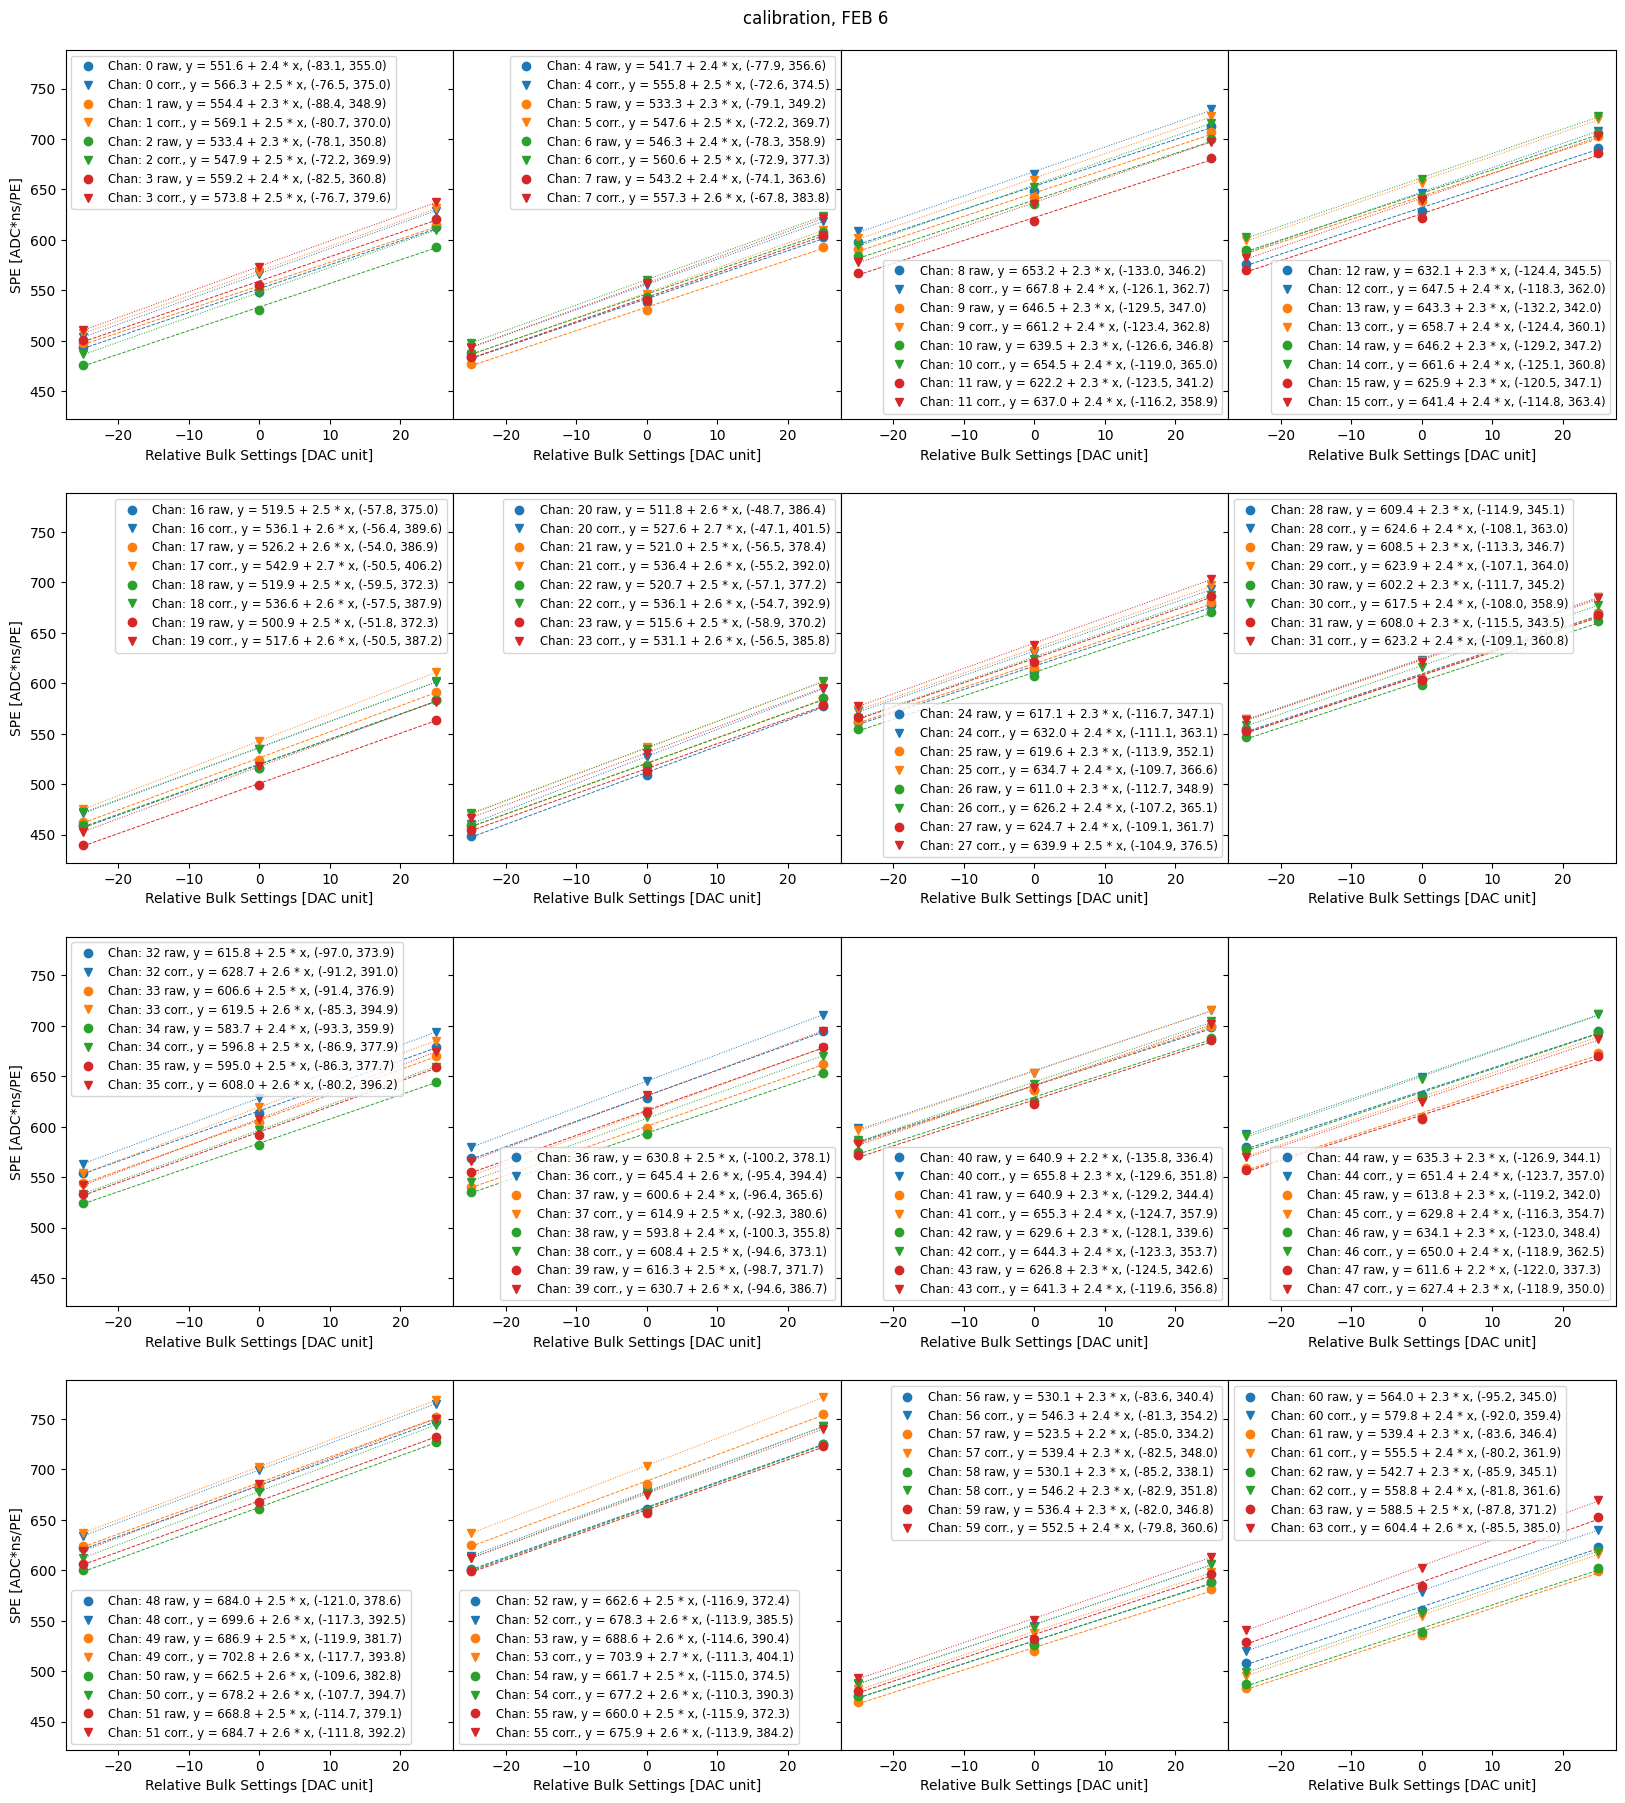

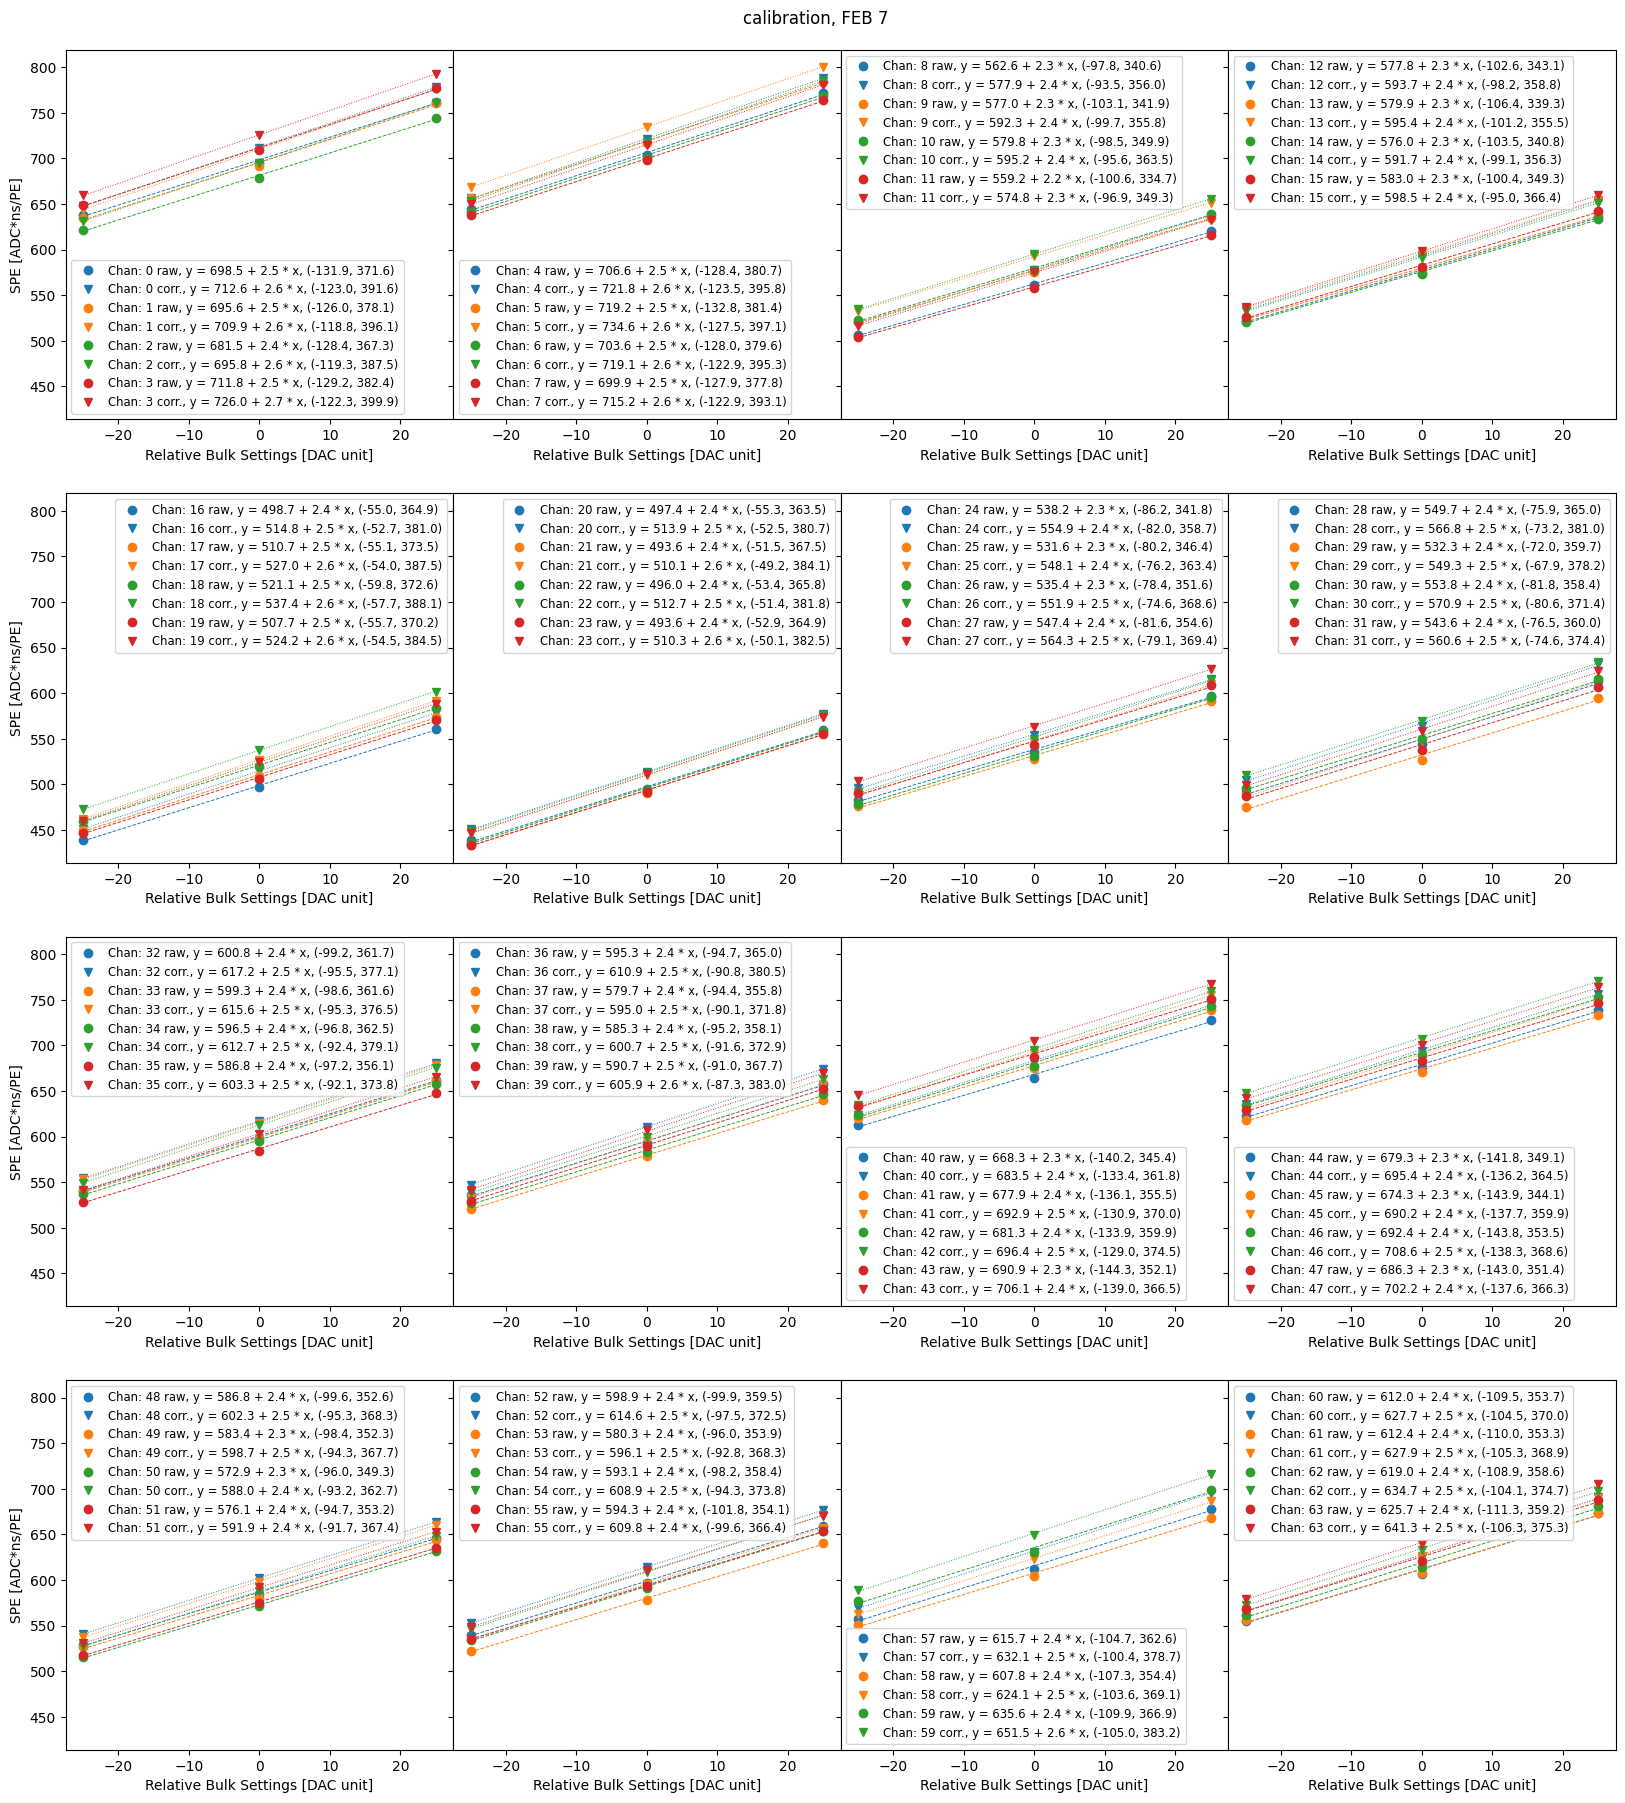

In [4]:
df = PortToDFwithBulk(fileList, filepath.datatag["bulk_scan_crvaging016_0"]["bulk"])
df_calib = CalibrateByScan(df)
display(df_calib)

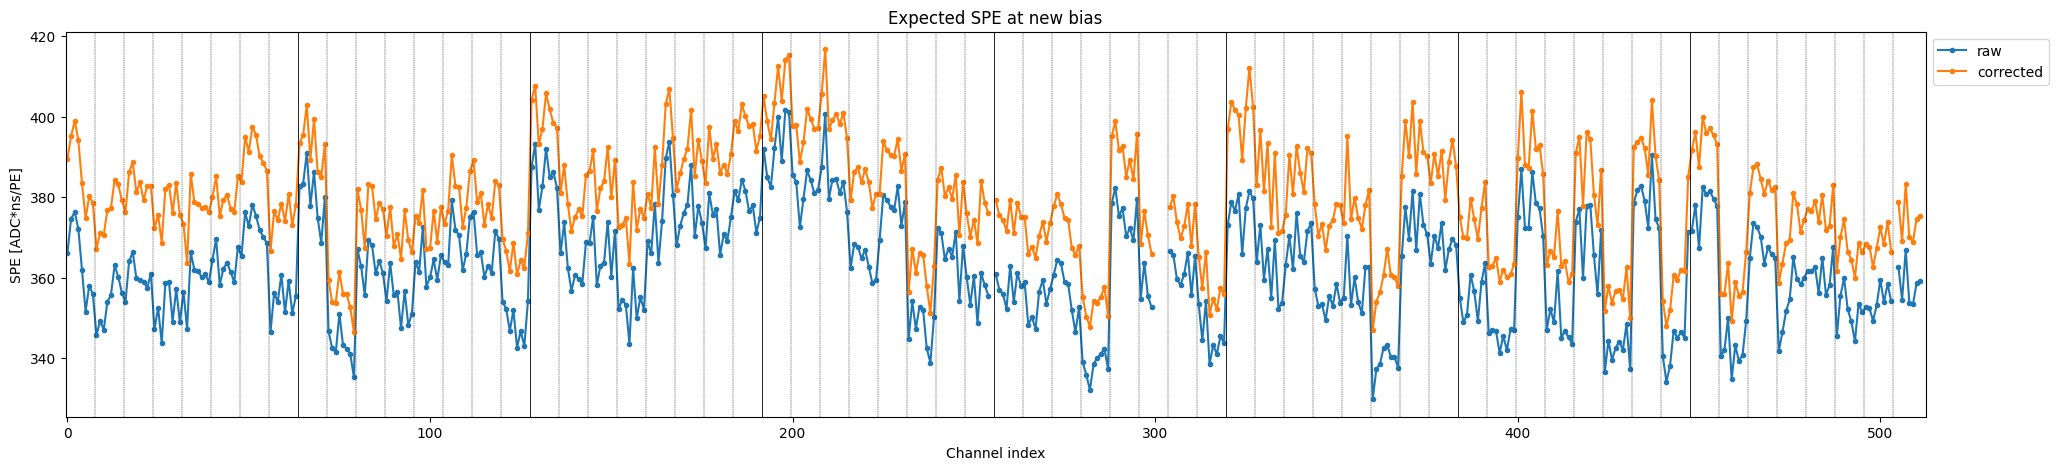

In [5]:
# check consistency
plt.figure(figsize = (24,5))
plt.plot(np.add(df_calib['FEB']*64,df_calib['ch']), df_calib['bulkRelativeSettingRaw'], '.-', label=('raw'))
plt.plot(np.add(df_calib['FEB']*64,df_calib['ch']), df_calib['bulkRelativeSettingCorr'], '.-', label=('corrected'))
plt.title("Relative shifts needed in bulk units")
plt.xlabel("Channel index")
plt.ylabel("Shift (20mV/DAC)")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iFEB in range(8):
    for iAFE in range(8):
        plt.axvline(x=8*(iFEB*8+iAFE)-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.6 if iAFE==0 else 0.3)
plt.gca().set_xlim(-0.5, 8*64+0.5)
plt.show()

plt.figure(figsize = (24,5))
plt.plot(np.add(df_calib['FEB']*64,df_calib['ch']), df_calib['SPErefRaw'], '.-', label=('raw'))
plt.plot(np.add(df_calib['FEB']*64,df_calib['ch']), df_calib['SPErefCorr'], '.-', label=('corrected'))
plt.title("Expected SPE at new bias")
plt.xlabel("Channel index")
plt.ylabel("SPE [ADC*ns/PE]")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iFEB in range(8):
    for iAFE in range(8):
        plt.axvline(x=8*(iFEB*8+iAFE)-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.6 if iAFE==0 else 0.3)
plt.gca().set_xlim(-0.5, 8*64+0.5)
plt.show()

In [6]:
def UpdateSettings(originalSettingsFiles, outputSettingsFiles, df_calib, useCorr = True, AFEmask = 0xff):
    FEBs = df_calib['FEB'].unique()
    FEBs = np.sort(FEBs)

    for FEB in FEBs:
        print("FEB%i"%FEB)
        myFilename = os.path.join(settings_dir, originalSettingsFiles[FEB])
        mySettings = settings_file.settingsFile(myFilename)
        print("before change")
        mySettings.Print()
        for chan in range(64):
            df_calib_ = df_calib.query("FEB==%i & ch==%i"%(FEB, chan)).reset_index()
            # display(df_calib_)
            if df_calib_ is not None and len(df_calib_.index)>0:
                adjustment = df_calib_['bulkRelativeSettingCorr'][0] if useCorr else df_calib_['bulkRelativeSettingRaw'][0]
                if np.isnan(adjustment):
                    mySettings.trims[chan] = 0xdead
                else:
                    mySettings.trims[chan] += int(adjustment * MV_PER_BULK / MV_PER_TRIM)
        print("no balance")
        mySettings.Print()
        mySettings.BalanceBiasTrimBulk()
        print("after change")
        mySettings.Print()
        print("\n\n\n")
        if outputSettingsFiles != None:
            mySettings.DumpToTxt(os.path.join(settings_dir, outputSettingsFiles[FEB]))
        else:
            mySettings.DumpToTxt(None, AFEmask)
    return

In [7]:
initial_settings_files = ["SettingsNeutralTrim.txt",
                          "SettingsNeutralTrim.txt",
                          "SettingsNeutralTrim.txt",
                          "SettingsNeutralTrim.txt",
                          "SettingsNeutralTrim.txt",
                          "SettingsNeutralTrim.txt",
                          "SettingsNeutralTrim.txt",
                          "SettingsNeutralTrim.txt"]
output_settings_files = ["Settings_crvaging-016_FEB%i_sync402.txt"%i for i in range(8)]

UpdateSettings(initial_settings_files, output_settings_files, df_calib, True) # used corrected to 20 degC

FEB0
before change
BULK| TRIM                           |GAIN
----+--------------------------------+----
ABE |800 800 800 800 800 800 800 800 |384
ABE |800 800 800 800 800 800 800 800 |384
ABE |800 800 800 800 800 800 800 800 |384
ABE |800 800 800 800 800 800 800 800 |384
ABE |800 800 800 800 800 800 800 800 |384
ABE |800 800 800 800 800 800 800 800 |384
ABE |800 800 800 800 800 800 800 800 |384
ABE |800 800 800 800 800 800 800 800 |384
no balance
BULK| TRIM                           |GAIN
----+--------------------------------+----
ABE |B2E AFC AFC B3E AFA B25 B11 B18 |384
ABE |C45 C40 C71 C48 C69 C5C C72 C8C |384
ABE |AEB B37 B0F B40 B57 B57 AFB B2A |384
ABE |BB1 BCB B7B B9D BB3 BAD B92 BD4 |384
ABE |BB4 B5C B87 B7E BA3 B92 B80 B8B |384
ABE |C89 C90 C8B C70 C5B C76 CBF C7D |384
ABE |B0B B0A B48 B0C AD6 B2E B48 B52 |384
ABE |C05 BB9 C0D BE7 BEA BF1 BE4 BC1 |384
after change
BULK| TRIM                           |GAIN
----+--------------------------------+----
A6F |818 7E6 7E6 828 7E4 80